In [1]:
%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('..')

import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import color.data.colors_big as dataset

In [3]:
# Choose embedding file
datasets_path = os.path.join('..', 'datasets')
emb_dir = os.path.join(datasets_path, 'embeddings')
emb_files = [os.path.join(emb_dir, f) for f in os.listdir(emb_dir)]
emb_dims = 50 # 50, 100, 200, 300
emb_file = list(filter(lambda f: str(emb_dims) in f, emb_files))[0]
emb_file

'../datasets/embeddings/glove.6B.50d.txt'

In [4]:
# Parse embeddings
embs = {}
with open(emb_file, 'r') as x:
    for line in x:
        comps = line.split()
        embs[comps[0]] = comps[1:]
len(embs)

400000

In [9]:
# Embedding Characters
emb_words = set(embs)
emb_chars = set()
for word in emb_words:
    for char in word:
        emb_chars.add(char)
print(len(emb_chars))
#emb_chars

489


In [10]:
# Extract words from color names
color_words = set()
color_map = dataset.load_color_names()
print('Color map:', color_map.shape)
for name in color_map['name']:
    for comps in name.split():
        color_words.add(comps.lower())
len(color_words)

Color map: (18081, 4)


9807

In [13]:
# Color names characters
color_chars = set()
for word in color_words:
    for char in word:
        color_chars.add(char)
print(len(color_chars))
# color_chars

90


In [15]:
# Overlaps
common_words = color_words & emb_words
print('Common Words: {} [{:.2f}%]'.format(len(common_words), len(common_words)*100/len(color_words)))

common_chars = color_chars & emb_chars
print('Common Characters: {} [{:.2f}%]'.format(len(common_chars), len(common_chars)*100/len(color_chars)))

print('Missing Words (50):')
print(list(color_words - emb_words)[:50])

print('Missing Characters:')
print(list(color_chars - emb_chars))


Common Words: 8300 [84.63%]
Common Characters: 88 [97.78%]
Missing Words (50):
['lippie', 'foncé', 'âbi', 'transtasman', 'stonewash', "robin's", 'cervela', 'trixter', 'kaltes', 'who-dun-it', 'dobunezumi', 'celestyn', 'butterum', 'hormagaunt', 'cornsnake', 'syhar', 'benikeshinezumi', 'truesky', 'silithus', 'hopbush', 'khemri', 'kuretake', 'carissima', 'xâkestari', 'icterine', 'skrag', 'registra', 'skarsnik', 'cuit', 'sandgrass', 'lakelike', "kelp'thar", "bugman's", 'fluro', 'verditter', 'grainfield', 'calcedony', 'froly', 'figue', 'fulgurite', 'peptalk', "cleo's", 'villandry', 'kurumizome', 'argeotus', 'seryi', 'pinktone', 'crystalsong', 'nurgling', "bay's"]
Missing Characters:
['ǜ', 'ǎ']


In [16]:
# Get embeddings for words
# For known words (which have embeddings) just lookup the embedding
# For any other word, generate a random embedding
known_words = ['red', 'black', 'peachy', 'watermelon', 'dog']
unknown_words = ['sussie', 'truesky', "elmer's", 'skavenblight', "bunny's"]
for word in [*known_words, *unknown_words]:
    if word in embs:
        known = True
        emb = np.array(embs[word])
    else:
        known = False
        emb = np.random.rand(emb_dims) - 0.5  # Range (-0.5, 0.5)
    print("Word: {}, Known: {}, Emb Shape: {}\nEmbedding: {}".format(word, known, emb.shape, emb))

Word: red, Known: True, Emb Shape: (50,)
Embedding: ['-0.12878' '0.8798' '-0.60694' '0.12934' '0.5868' '-0.038246' '-1.0408'
 '-0.52881' '-0.29563' '-0.72567' '0.21189' '0.17112' '0.19173' '0.36099'
 '0.032672' '-0.2743' '-0.19291' '-0.10909' '-1.0057' '-0.93901' '-1.0207'
 '-0.69995' '0.57182' '-0.45136' '-1.2145' '-1.1954' '-0.32758' '1.4921'
 '0.54574' '-1.0008' '2.845' '0.26479' '-0.49938' '0.34366' '-0.12574'
 '0.5905' '-0.037696' '-0.47175' '0.050825' '-0.20362' '0.13695' '0.26686'
 '-0.19461' '-0.75482' '1.0303' '-0.057467' '-0.32327' '-0.7712'
 '-0.16764' '-0.73835']
Word: black, Known: True, Emb Shape: (50,)
Embedding: ['-0.96256' '0.65329' '-0.55152' '-0.41065' '0.80223' '0.9833' '-0.96007'
 '-1.029' '-0.47013' '-0.6812' '0.071232' '-0.25591' '0.60577' '0.29845'
 '-0.1837' '-0.26064' '-0.038707' '0.11412' '-0.72028' '-1.2694'
 '-0.73858' '0.3357' '0.44293' '0.02566' '-0.97692' '-1.6867' '-0.88665'
 '0.75824' '0.18836' '-0.6932' '2.6144' '0.11718' '-0.45564' '-0.42953'
 '-0.05

In [22]:
# Check similarity b/w words
def similarity(x, y):
    return np.dot(x, y.T) / (np.sqrt(np.dot(x, x.T)) * np.sqrt(np.dot(y, y.T)))

words = [
    ['woman', 'kitchen'],
    ['woman', 'object'],
    ['woman', 'woman'],
]
for word1, word2 in words:
    emb1, emb2 = np.array(embs[word1]).astype(np.float), np.array(embs[word2]).astype(np.float)
    print('Similarity b/w "{}" and "{}" is {}'.format(word1, word2, similarity(emb1, emb2)))

Similarity b/w "woman" and "kitchen" is 0.4181231013837278
Similarity b/w "woman" and "object" is 0.4139111260693676
Similarity b/w "woman" and "woman" is 0.9999999999999999


In [23]:
# Create embedding matrix
embs_words = list(embs.keys())
embs_matrix = np.array(list(map(lambda w: embs[w], embs_words))).astype(np.float)
embs_matrix.shape

(400000, 50)

In [24]:
# Get closest words for embeddings
emb_red = np.array(['-0.12878', '0.8798', '-0.60694', '0.12934', '0.5868', '-0.038246', '-1.0408',
 '-0.52881', '-0.29563', '-0.72567', '0.21189', '0.17112', '0.19173', '0.36099',
 '0.032672', '-0.2743', '-0.19291', '-0.10909', '-1.0057', '-0.93901', '-1.0207',
 '-0.69995', '0.57182', '-0.45136', '-1.2145', '-1.1954', '-0.32758', '1.4921',
 '0.54574', '-1.0008', '2.845', '0.26479', '-0.49938', '0.34366', '-0.12574',
 '0.5905', '-0.037696', '-0.47175', '0.050825', '-0.20362', '0.13695', '0.26686',
 '-0.19461', '-0.75482', '1.0303', '-0.057467', '-0.32327', '-0.7712',
 '-0.16764', '-0.73835']).astype(np.float).reshape(50,1)

emb_random = np.random.rand(50) - 0.5

emb_curr = emb_red

embs_mag = np.sqrt(np.sum(embs_matrix*embs_matrix, axis=1)).reshape(-1)
emb_curr_mag = np.sqrt(np.dot(emb_curr.T, emb_curr)).reshape(-1)
emb_dot = np.dot(embs_matrix, emb_curr).reshape(-1)

embs_sim = emb_dot / (embs_mag * emb_curr_mag)

# Most similar word
print('Most similar word:', embs_words[np.argmax(embs_sim)], embs_sim[np.argmax(embs_sim)])

# Most dissimilar word
print('Most dissililar word', embs_words[np.argmin(embs_sim)], embs_sim[np.argmin(embs_sim)])

Most similar word: red 0.9999999999999999
Most dissililar word esber -0.7445946751683282


In [25]:
# Embedding Sample
idx = np.arange(len(embs))
np.random.shuffle(idx)
samp_size = 10000
samp = np.array(list(embs.values()))[idx[:10000]].astype(np.float)
samp.shape

(10000, 50)

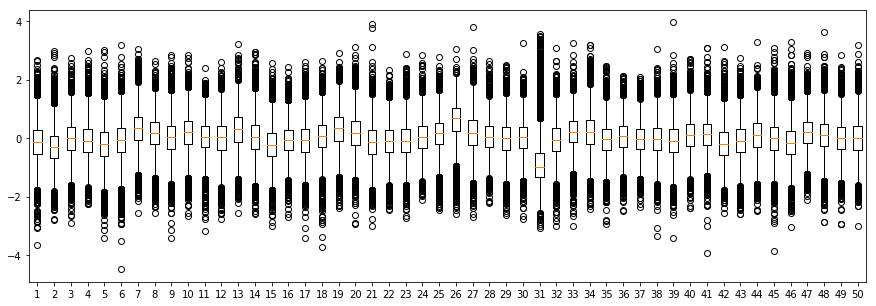

In [26]:
# Embedding Distribution
plt.figure(figsize=(15,5))
plt.boxplot(samp)
plt.show()

In [27]:
# Summary
df = pd.DataFrame(samp)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-0.138054,-0.292305,-0.016683,-0.059094,-0.198727,-0.076052,0.333985,0.161972,0.031196,0.183460,...,0.141852,-0.171824,-0.078247,0.088793,-0.004687,-0.131602,0.197604,0.106522,0.005604,0.011258
std,0.642208,0.609354,0.610317,0.628517,0.643187,0.666607,0.626433,0.604441,0.648686,0.614791,...,0.568546,0.608759,0.612516,0.622390,0.630908,0.624256,0.555640,0.617296,0.600100,0.628023
min,-3.647400,-2.799800,-2.904400,-2.264800,-3.410600,-4.486800,-2.572700,-2.566100,-3.416900,-2.660400,...,-3.910200,-2.539900,-2.588300,-2.481900,-3.854000,-3.041900,-2.095000,-2.876900,-2.937000,-3.015600
25%,-0.542450,-0.684808,-0.409752,-0.472715,-0.607618,-0.480152,-0.056574,-0.210663,-0.369505,-0.196430,...,-0.214670,-0.581325,-0.469445,-0.313218,-0.392848,-0.532432,-0.155707,-0.281580,-0.375945,-0.396345
50%,-0.141760,-0.316395,-0.008651,-0.088881,-0.206480,-0.058796,0.350245,0.195835,0.029669,0.204450,...,0.137190,-0.201155,-0.096781,0.103555,-0.005962,-0.148905,0.198395,0.114920,0.002022,-0.002842
75%,0.265052,0.067151,0.383660,0.329248,0.211207,0.346942,0.740123,0.557335,0.431920,0.581925,...,0.495223,0.197960,0.310578,0.509625,0.393985,0.242735,0.549260,0.495063,0.384310,0.411355
max,2.686200,2.970300,2.730100,2.966600,3.005900,3.185800,3.039400,2.634300,2.840500,2.837700,...,3.102900,3.120100,2.750200,3.294500,3.079700,3.305600,2.906900,3.644400,2.847400,3.180000


In [28]:
print('IQR:', np.percentile(samp, 25), np.percentile(samp, 75))
print('Mean:', np.mean(samp))

IQR: -0.38842 0.43659249999999994
Mean: 0.0209337838810184
